**Install & Imports**

In [ ]:
!pip -q install scikit-learn joblib gradio pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib


**Data Loading**

In [ ]:
df = pd.read_csv("insurance.csv")

print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include="all"))


Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


**Data Preprocessing**

In [4]:
# Clean column names
df.columns = [c.strip().lower() for c in df.columns]
print("Columns:", df.columns.tolist())

# Check missing values
print("Missing values per column:")
display(df.isna().sum())

# Remove duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print("Removed duplicates:", before - after)

# Outlier handling
low, high = df["charges"].quantile([0.01, 0.99])
df["charges"] = df["charges"].clip(low, high)
print("Clipped charges to 1%-99% quantiles:", low, high)

# Feature engineering
df["is_smoker"] = (df["smoker"].astype(str).str.lower() == "yes").astype(int)

def bmi_cat(bmi):
    if bmi < 18.5: return "underweight"
    if bmi < 25: return "normal"
    if bmi < 30: return "overweight"
    return "obese"

df["bmi_category"] = df["bmi"].apply(bmi_cat)

display(df[["bmi", "bmi_category", "smoker", "is_smoker"]].head())

# Split features/target
X = df.drop(columns=["charges"])
y = df["charges"]

print("X shape:", X.shape)
print("y shape:", y.shape)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


# Identify numeric/categorical columns
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

print("Numeric:", num_features)
print("Categorical:", cat_features)




Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'is_smoker', 'bmi_category']
Missing values per column:


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0
is_smoker,0
bmi_category,0


Removed duplicates: 0
Clipped charges to 1%-99% quantiles: 1253.3097215999999 48530.512735920005


,bmi,bmi_category,smoker,is_smoker
0,27.900,overweight,yes,1
1,33.770,obese,no,0
2,33.000,obese,no,0
3,22.705,normal,no,0
4,28.880,overweight,no,0


X shape: (1337, 8)
y shape: (1337,)
Train: (1069, 8) Test: (268, 8)
Numeric: ['age', 'bmi', 'children', 'is_smoker']
Categorical: ['sex', 'smoker', 'region', 'bmi_category']


**Pipeline Creation**

In [5]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

model = RandomForestRegressor(random_state=42)

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

pipe


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children',
                                                   'is_smoker']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker', 'region',
                                                   'bmi_category'])])),
                ('model', RandomForestRegressor(random_state=42))])

**Primary Model Selection**

# *Why Random Forest Regressor?*

Works well on tabular data and captures non-linear relationships

Handles mixed features (after encoding) and is strong baseline performance

Less sensitive to outliers compared to linear models

**Model Training**

In [6]:
pipe.fit(X_train, y_train)
print("Model trained successfully.")


Model trained successfully.


**Cross-Validation**

In [7]:
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")
print("CV R2 scores:", cv_scores)
print("Average CV R2:", cv_scores.mean())
print("Std CV R2:", cv_scores.std())


CV R2 scores: [0.80565556 0.82985428 0.82368743 0.82523069 0.82461751]
Average CV R2: 0.8218090949272974
Std CV R2: 0.008352057943851294


**Hyperparameter Tuning**

In [8]:
param_distributions = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [None, 5, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.7, 1.0],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=25,
    scoring="r2",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("Best Params:", search.best_params_)
print("Best CV R2:", search.best_score_)

# parameters tested
results = pd.DataFrame(search.cv_results_)
show_cols = ["mean_test_score", "std_test_score", "rank_test_score", "params"]
display(results[show_cols].sort_values("rank_test_score").head(10))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Params: {'model__n_estimators': 800, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 1.0, 'model__max_depth': 5}
Best CV R2: 0.8450332646804519


,mean_test_score,std_test_score,rank_test_score,params
18,0.845033,0.017274,1,"{'model__n_estimators': 800, 'model__min_sampl..."
9,0.842080,0.016114,2,"{'model__n_estimators': 600, 'model__min_sampl..."
11,0.841733,0.012179,3,"{'model__n_estimators': 200, 'model__min_sampl..."
13,0.841373,0.016296,4,"{'model__n_estimators': 400, 'model__min_sampl..."
15,0.841040,0.011877,5,"{'model__n_estimators': 200, 'model__min_sampl..."
8,0.841040,0.011877,5,"{'model__n_estimators': 200, 'model__min_sampl..."
2,0.841035,0.012658,7,"{'model__n_estimators': 600, 'model__min_sampl..."
0,0.840976,0.013168,8,"{'model__n_estimators': 200, 'model__min_sampl..."
17,0.840707,0.013181,9,"{'model__n_estimators': 800, 'model__min_sampl..."
24,0.840650,0.012674,10,"{'model__n_estimators': 600, 'model__min_sampl..."


**Best Model Selection**

In [9]:
best_model = search.best_estimator_
best_model


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children',
                                                   'is_smoker']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker', 'region',
                                                   'bmi_category'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, min_samples_split=5,
                                       n_estimators=800, random_state=42))])

**Model Performance Evaluation**

Test MAE : 2249.2037010737104
Test RMSE: 3892.57178594203
Test R2  : 0.9121530735944058


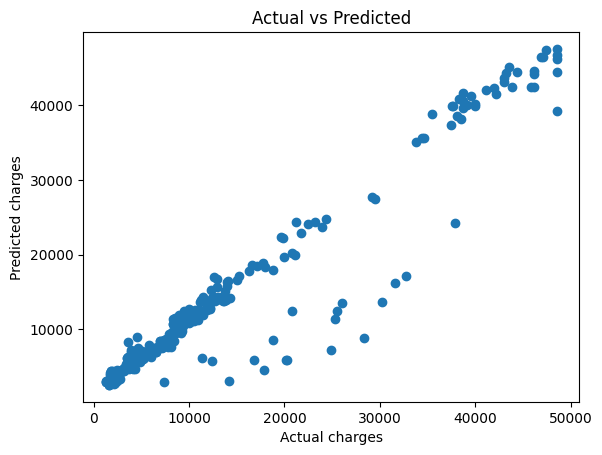

Saved: insurance_model.joblib


In [11]:
pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("Test MAE :", mae)
print("Test RMSE:", rmse)
print("Test R2  :", r2)

# Simple plot
plt.figure()
plt.scatter(y_test, pred)
plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
plt.title("Actual vs Predicted")
plt.show()

# Save model
joblib.dump(best_model, "insurance_model.joblib")
print("Saved: insurance_model.joblib")

**Web Interface with Gradio**

In [12]:
import gradio as gr

loaded_model = joblib.load("insurance_model.joblib")

def predict_insurance(age, sex, bmi, children, smoker, region):
    row = pd.DataFrame([{
        "age": age,
        "sex": sex,
        "bmi": bmi,
        "children": children,
        "smoker": smoker,
        "region": region,
        "is_smoker": 1 if str(smoker).lower()=="yes" else 0,
        "bmi_category": ("underweight" if bmi < 18.5 else
                         "normal" if bmi < 25 else
                         "overweight" if bmi < 30 else "obese")
    }])
    p = loaded_model.predict(row)[0]
    return f"Predicted insurance charge: ${p:,.2f}"

demo = gr.Interface(
    fn=predict_insurance,
    inputs=[
        gr.Number(label="Age", value=30),
        gr.Dropdown(["male","female"], label="Sex", value="male"),
        gr.Number(label="BMI", value=27.5),
        gr.Number(label="Children", value=0),
        gr.Dropdown(["yes","no"], label="Smoker", value="no"),
        gr.Dropdown(["northeast","northwest","southeast","southwest"], label="Region", value="northeast"),
    ],
    outputs="text",
    title="Medical Insurance Cost Prediction"
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aa151e2067d325cfc9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
